> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- 14 Subjects, therefore random guessing would be 7.14% correct on average

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data

In [27]:
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [28]:
#dec_flattened_df1 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_full_flattened_df1.csv")
#dec_flattened_df2 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_full_flattened_df2.csv")
dec_flattened_df1 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_flattened_df1.csv")
dec_flattened_df2 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_flattened_df2.csv")
dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))

if (dec_flattened_df.columns[0] == 'Unnamed: 0'):
    dec_flattened_df.drop(dec_flattened_df.columns[0], axis=1, inplace=True)

print(dec_flattened_df.shape)
dec_flattened_df.head(5)

(2128, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,METACPHS_S106,0,1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,METACPHS_S106,0,2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,METACPHS_S106,0,3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,METACPHS_S106,0,4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


In [29]:
dec_flattened_df.tail(5)

,Subject,Condition,Update Number,Flattened Decoder
1059,METACPHS_S112,7,14,[ 1.72746602e-01 -6.46751979e-01 1.08992359e+...
1060,METACPHS_S112,7,15,[-3.07344160e-02 6.03699218e-02 4.26590818e-...
1061,METACPHS_S112,7,16,[ 9.17285360e-02 1.60315698e-01 3.93406660e-...
1062,METACPHS_S112,7,17,[ 1.20744948e-01 -4.79756037e-01 2.03405148e+...
1063,METACPHS_S112,7,18,[ 0.04912337 0.06417236 2.15931676 -2.307400...


In [30]:
# SPLIT BASED ON CONDITION NUMBERS
# initialization conditions
pos_init = [0, 1, 4, 5]
neg_init = [2, 3, 6, 7]

In [31]:
pos_dec_df = dec_flattened_df[dec_flattened_df["Condition"].isin(pos_init)]
neg_dec_df = dec_flattened_df[dec_flattened_df["Condition"].isin(neg_init)]

In [32]:
pos_dec_df.head()

,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,METACPHS_S106,0,1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,METACPHS_S106,0,2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,METACPHS_S106,0,3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,METACPHS_S106,0,4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


In [33]:
pos_dec_expanded_df = pd.DataFrame()
for my_row in range(pos_dec_df.shape[0]):
    test=pd.DataFrame(pos_dec_df.iloc[my_row,3].strip("[]").split()).T
    pos_dec_expanded_df = pd.concat((pos_dec_expanded_df, test))

pos_dec_expanded_df.reset_index(inplace=True, drop=True)
pos_dec_expanded_df.insert(loc=0, column='Update Number', value=list(pos_dec_df['Update Number']))
pos_dec_expanded_df.insert(loc=0, column='Condition', value=list(pos_dec_df['Condition']))
pos_dec_expanded_df.insert(loc=0, column='Subject', value=list(pos_dec_df['Subject']))

##################################################################

neg_dec_expanded_df = pd.DataFrame()
for my_row in range(neg_dec_df.shape[0]):
    test=pd.DataFrame(neg_dec_df.iloc[my_row,3].strip("[]").split()).T
    neg_dec_expanded_df = pd.concat((neg_dec_expanded_df, test))

neg_dec_expanded_df.reset_index(inplace=True, drop=True)
neg_dec_expanded_df.insert(loc=0, column='Update Number', value=list(neg_dec_df['Update Number']))
neg_dec_expanded_df.insert(loc=0, column='Condition', value=list(neg_dec_df['Condition']))
neg_dec_expanded_df.insert(loc=0, column='Subject', value=list(neg_dec_df['Subject']))

print(neg_dec_expanded_df.shape)
neg_dec_expanded_df.head()

(1064, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,2,0,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
1,METACPHS_S106,2,1,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
2,METACPHS_S106,2,2,0.82593316,-1.469018,0.5718147,0.30386287,0.20599231,0.23858401,-0.45009008,...,-0.40060644,-0.15447305,-0.32237114,0.16487292,-0.67910006,-1.08957169,-0.7687223,0.41108874,0.14403131,1.6355224
3,METACPHS_S106,2,3,1.05893088e+00,3.75012173e-01,2.82296123e-01,-1.39928741e+00,3.70222853e-01,-1.23905949e+00,8.51994369e-01,...,-9.40543878e-01,3.91353932e-01,8.95968481e-01,-1.13562554e+00,6.79701079e-02,4.52495748e-02,5.58157547e-01,9.75948689e-01,1.86490780e-01,-8.37941497e-01
4,METACPHS_S106,2,4,1.37451487,0.39408145,-0.84023372,0.01570676,-0.00417416,-0.12700323,0.6018257,...,0.12449128,-0.61832039,0.11221758,-0.76469522,-0.35952029,-1.06020649,-0.92117856,0.13845195,1.56951535,-0.34585314


# Concat All 19 Update Model Results
> Should I be trying to use the same model but predicting on different datasets too?

In [34]:
def make_all_update_models(flattened_input_df, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    for i in range(19):
        print(f"{i} of {19}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [35]:
# Setting all column names to strings, idk why this was breaking it just now
pos_dec_expanded_df.columns = pos_dec_expanded_df.columns.astype(str)

full_pos_test_df = make_all_update_models(pos_dec_expanded_df)
full_pos_test_df.head(8)

0 of 19
1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19


,Algorithm,Test Acc,N
0,LogisticRegression(),0.0,0
0,KNeighborsClassifier(),0.0,0
0,GaussianNB(),100.0,0
0,LinearSVC(),0.0,0
0,SGDClassifier(),17.647,0
0,DecisionTreeClassifier(),100.0,0
0,GradientBoostingClassifier(),100.0,0
0,LogisticRegression(),0.0,1


In [36]:
# Setting all column names to strings, idk why this was breaking it just now
neg_dec_expanded_df.columns = neg_dec_expanded_df.columns.astype(str)

full_neg_test_df = make_all_update_models(neg_dec_expanded_df)
full_neg_test_df.head(8)

0 of 19
1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19


,Algorithm,Test Acc,N
0,LogisticRegression(),0.0,0
0,KNeighborsClassifier(),0.0,0
0,GaussianNB(),100.0,0
0,LinearSVC(),0.0,0
0,SGDClassifier(),5.882,0
0,DecisionTreeClassifier(),94.118,0
0,GradientBoostingClassifier(),94.118,0
0,LogisticRegression(),0.0,1


## Plot Accuracy As a Func of N

In [37]:
pos_lr_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LogisticRegression()']
pos_knn_df = full_pos_test_df[full_pos_test_df['Algorithm']=='KNeighborsClassifier()']
pos_svc_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LinearSVC()']
pos_sgd_df = full_pos_test_df[full_pos_test_df['Algorithm']=='SGDClassifier()']
pos_dt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='DecisionTreeClassifier()']
pos_gbt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='GradientBoostingClassifier()']

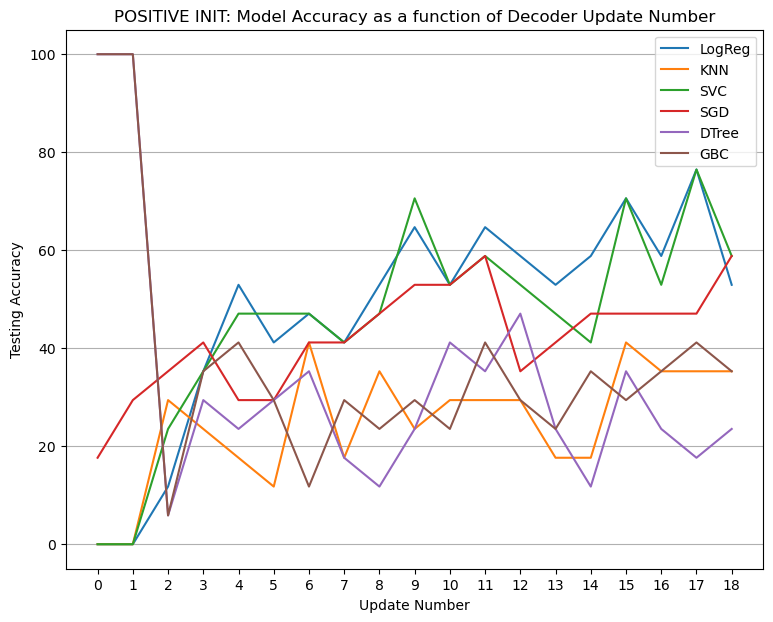

In [38]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, pos_lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, pos_knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, pos_svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, pos_sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, pos_dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, pos_gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('POSITIVE INIT: Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

In [39]:
neg_lr_df = full_neg_test_df[full_neg_test_df['Algorithm']=='LogisticRegression()']
neg_knn_df = full_neg_test_df[full_neg_test_df['Algorithm']=='KNeighborsClassifier()']
neg_svc_df = full_neg_test_df[full_neg_test_df['Algorithm']=='LinearSVC()']
neg_sgd_df = full_neg_test_df[full_neg_test_df['Algorithm']=='SGDClassifier()']
neg_dt_df = full_neg_test_df[full_neg_test_df['Algorithm']=='DecisionTreeClassifier()']
neg_gbt_df = full_neg_test_df[full_neg_test_df['Algorithm']=='GradientBoostingClassifier()']

In [40]:
neg_gbt_df.head()

,Algorithm,Test Acc,N
0,GradientBoostingClassifier(),94.118,0
0,GradientBoostingClassifier(),94.118,1
0,GradientBoostingClassifier(),11.765,2
0,GradientBoostingClassifier(),11.765,3
0,GradientBoostingClassifier(),52.941,4


Now plot for negative init case

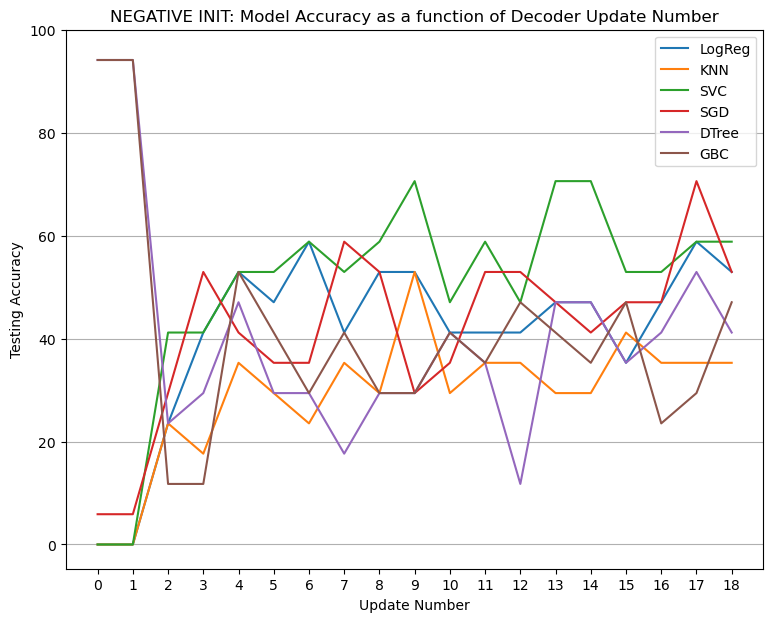

In [41]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, neg_lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, neg_knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, neg_svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, neg_sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, neg_dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, neg_gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('NEGATIVE INIT: Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

Accuracies get considerably worse.  From the original (NB 104), we had the following:
- SVC: 80
- LR: 70
- KNN: 57
- GBC: 53
- DTree: 38

However, this is of course a caveat here: when we split the data into the pos and neg condition dfs, we therefore trained the models with half as much data as they otherwise wouldv'e had (as compared to NB 104 for instance which had the entire dataset to train on).  So let's rerun the NB 104 code using just a random 50% of the full data

In [42]:
# Shuffle the DF
full_dec_df = pd.concat((neg_dec_expanded_df, neg_dec_expanded_df))
shuffled_dec_df = full_dec_df.sample(frac=1)
print(shuffled_dec_df.shape)
shuffled_dec_df.head()

(2128, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
1040,METACPHS_S112,6,14,0.02226886,-0.15717612,-0.02401614,-0.10970957,-0.20111244,-0.0813039,-0.5148712,...,-0.434417,-0.12658954,-0.13307662,0.12214698,-0.46394882,-0.34607872,0.43925135,-0.23655807,0.24784791,-0.42998771
432,METACPHS_S111,6,14,0.23528062,-0.22757447,0.56082875,-0.35723332,0.49075337,-0.74242009,-0.35631917,...,0.02055047,-0.22006711,-0.00329548,0.03084636,0.07758986,0.24424993,-0.09259443,0.14380113,-0.07655367,0.00613335
900,METACPHS_S110,7,7,6.03488482e-01,-3.55775334e-02,6.36925509e-02,4.55021077e-02,-4.87828548e-02,-6.62210088e-03,5.52130257e-02,...,-7.79172655e-02,-3.85718223e-02,-1.43577719e-01,1.87734131e-01,3.54217726e-01,-1.66125801e-01,2.72334059e-01,3.92669366e-01,-2.13359045e-01,-1.30928845e+00
371,METACPHS_S110,7,10,-0.14220957,-1.44902758,0.00371738,-0.05968287,0.02863515,-0.10898291,0.1974031,...,-0.06848254,-0.25029881,0.14789264,0.0301198,0.21780044,0.22184474,-0.19221082,0.42614232,0.01280811,-0.12831805
952,METACPHS_S111,6,2,6.54744574e-02,-4.53717049e-02,-1.00218936e-01,2.94389176e-02,-4.69464058e-01,1.75957120e-01,-9.22990576e-02,...,2.79080218e-01,-2.33133791e-01,-1.64139860e-01,8.02814357e-02,1.79030393e-01,4.59953226e-02,-1.19858830e-01,2.14024404e-01,-1.12169275e-01,3.58249539e-01


In [43]:
half_df = shuffled_dec_df.iloc[shuffled_dec_df.shape[0]//2:, :]
print(half_df.shape)
half_df.head()

(1064, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
865,METACPHS_S110,3,10,0.3752713,0.63329681,-0.63772085,-0.53503128,-0.23102424,-0.46270083,-0.3080258,...,-0.39432212,-0.41155058,-0.37420369,0.37983497,0.35199344,-0.25132408,-0.1894549,-1.17547381,0.19525359,-2.01865661
997,METACPHS_S112,2,9,-0.54468821,0.41182929,0.16864386,1.05222648,-0.06105107,-0.58507389,0.69817583,...,-0.35497992,0.46840908,-0.56648015,0.43150879,-1.18266664,0.99262084,-0.39557837,-0.0915932,-0.11097864,-0.80172609
2,METACPHS_S106,2,2,0.82593316,-1.469018,0.5718147,0.30386287,0.20599231,0.23858401,-0.45009008,...,-0.40060644,-0.15447305,-0.32237114,0.16487292,-0.67910006,-1.08957169,-0.7687223,0.41108874,0.14403131,1.6355224
190,METACPHS_S108,6,0,-5.21365318e-03,-1.91865429e-03,-3.88560707e-03,-1.38643333e-03,-7.31651883e-03,-3.19251742e-03,-9.98246047e-03,...,-6.88154911e-03,-9.14642423e-03,-1.94566580e-03,-9.86970395e-03,-7.66553042e-03,-8.54543182e-03,-6.09191142e-03,-6.33021234e-03,-5.20777057e-03,-5.90045304e-03
114,METACPHS_S107,6,0,-8.97360423e-03,-8.31381090e-03,-6.41220148e-03,-1.12539235e-03,-3.36881772e-03,-1.68942685e-03,-8.62278986e-03,...,-8.42358503e-03,-2.35925820e-03,-1.52956553e-03,-2.41583688e-03,-1.75725760e-03,-7.07813716e-03,-7.92085039e-03,-6.52980615e-03,-3.72468265e-03,-5.48093337e-03


In [44]:
half_df, half_test_df = nth_decoder_model(half_df, 18, my_models, test=True)
half_test_df.head(100)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),77.778,43.75,5,18
0,KNeighborsClassifier(),33.333,31.25,5,18
0,LinearSVC(),83.333,56.25,5,18
0,SGDClassifier(),69.444,37.5,5,18
0,DecisionTreeClassifier(),47.222,43.75,5,18
0,GradientBoostingClassifier(),61.111,25.0,5,18


In [45]:
half_test_df.iloc[:, 2]

0    43.75
0    31.25
0    56.25
0     37.5
0    43.75
0     25.0
Name: Test Acc, dtype: object

When comparing to the test accuracies all the graphs and testing dataframes, notice that this final performance is actually still better for all models, which was unexpected (especially for KNN!).  E.g. we observe that splitting into positive and negative conditions (initializations) does NOT actually improve the capabilities of an adverary, as the adversary's ML model performs better when just a random sample of all data is taken.
> A smaller caveat here is that we only tested one random sample of the data, so perhaps this was just a "good" initialization of random training data